In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os
import glob


In [15]:
# initial parameters
epochs = 100
lr = 1e-3
batch_size = 128
img_dims = (128,128,3)

data = []
labels = []

# load image files from the dataset
image_files = [f for f in glob.glob(r'Gender-Detection/gender_dataset_face' + "/**/*", recursive=True) if not os.path.isdir(f)]
random.shuffle(image_files)


In [16]:
# converting images to arrays and labelling the categories
for img in image_files:

    image = cv2.imread(img)
    
    image = cv2.resize(image, (img_dims[0],img_dims[1]))
    image = img_to_array(image)
        
    data.append(image)

    label = img.split(os.path.sep)[-2] # C:\Files\gender_dataset_face\woman\face_1162.jpg
    if label == "woman":
        label = 1
    else:
        label = 0
        
    labels.append([label]) # [[1], [0], [0], ...]


In [17]:
# pre-processing
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

# split dataset for training and validation
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.15,
                                                  random_state=42)

trainY = to_categorical(trainY, num_classes=2) # [[1, 0], [0, 1], [0, 1], ...]
testY = to_categorical(testY, num_classes=2)


In [18]:
# augmenting datset 
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.3,
                         horizontal_flip=True,vertical_flip=True, fill_mode="nearest")


In [19]:
# define model
def build(width, height, depth, classes):
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1

    if K.image_data_format() == "channels_first": #Returns a string, either 'channels_first' or 'channels_last'
        inputShape = (depth, height, width)
        chanDim = 1
    
    # The axis that should be normalized, after a Conv2D layer with data_format="channels_first", 
    # set axis=1 in BatchNormalization.

    model.add(Conv2D(16, (3,3), padding="same", input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3,3)))

    model.add(Conv2D(16, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))


    model.add(Conv2D(32, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3,3)))

    model.add(Conv2D(32, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    

    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    
    model.add(Dense(512))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    model.add(Dense(512))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    model.add(Dense(classes))
    model.add(Activation("sigmoid"))

    return model


In [20]:
# build model
model = build(width=img_dims[0], height=img_dims[1], depth=img_dims[2],
                            classes=2)

# compile the model
opt = Adam(learning_rate=lr, decay=lr/epochs)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy", 'binary_crossentropy'])


In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 activation_9 (Activation)   (None, 128, 128, 16)      0         
                                                                 
 batch_normalization_8 (Batc  (None, 128, 128, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 42, 42, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 42, 42, 16)        2320      
                                                                 
 activation_10 (Activation)  (None, 42, 42, 16)       

In [22]:
# train the model
H = model.fit(aug.flow(trainX, trainY, batch_size=batch_size),
                        validation_data=(testX,testY),
                        steps_per_epoch=len(trainX) // batch_size,
                        epochs=epochs, verbose=1)


Epoch 1/100


2022-04-26 21:59:39.005010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - ETA: 0s - loss: 0.7208 - accuracy: 0.6758 - binary_crossentropy: 0.7208

2022-04-26 21:59:42.445462: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 4s 210ms/step - loss: 0.7208 - accuracy: 0.6758 - binary_crossentropy: 0.7208 - val_loss: 0.6930 - val_accuracy: 0.5101 - val_binary_crossentropy: 0.6930
Epoch 2/100
15/15 [==============================] - 3s 178ms/step - loss: 0.5584 - accuracy: 0.7566 - binary_crossentropy: 0.5584 - val_loss: 0.7403 - val_accuracy: 0.5101 - val_binary_crossentropy: 0.7403
Epoch 3/100
15/15 [==============================] - 3s 189ms/step - loss: 0.5043 - accuracy: 0.7833 - binary_crossentropy: 0.5043 - val_loss: 0.6983 - val_accuracy: 0.4928 - val_binary_crossentropy: 0.6983
Epoch 4/100
15/15 [==============================] - 3s 178ms/step - loss: 0.4715 - accuracy: 0.7811 - binary_crossentropy: 0.4715 - val_loss: 0.6941 - val_accuracy: 0.5187 - val_binary_crossentropy: 0.6941
Epoch 5/100
15/15 [==============================] - 3s 175ms/step - loss: 0.4179 - accuracy: 0.8160 - binary_crossentropy: 0.4179 - val_loss: 0.7225 - val_accuracy: 0.5101 - val_binar

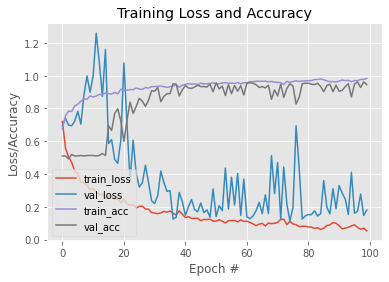

In [30]:
# plot training/validation loss/accuracy
plt.style.use("ggplot")
plt.figure()
N = epochs
plt.plot(np.arange(0,N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0,N), H.history["val_accuracy"], label="val_acc")


plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

# save plot to disk
#plt.savefig('plot.png')

In [24]:
model.evaluate(testX, testY, verbose=1)

11/11 [==============================] - 0s 9ms/step - loss: 0.1793 - accuracy: 0.9452 - binary_crossentropy: 0.1793


[0.1793467402458191, 0.9452450275421143, 0.1793467402458191]

In [25]:
import pickle
from datetime import date

pickle.dump(model, open('model.pkl', 'wb'))

INFO:tensorflow:Assets written to: ram://8bde8939-1a0c-4cb2-8306-c57fe6661826/assets


In [27]:
# real save by date
import pickle
from datetime import date

#pickle.dump(model, open(f'model.pkl{date.today()}', 'wb'))

INFO:tensorflow:Assets written to: ram://4c493cf5-d728-4efe-bda8-e45f6db8d105/assets
